# import stuff 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import objectives
from keras.datasets import mnist
from keras import backend as K

# encoder/decode network size

In [20]:
batch_size=100
digit_size=28
original_dim=784
intermediate_dim=256
latent_dim=2

nb_epochs=50
epsilon_std=1.0

# encoder

In [ ]:
#recognition network
X=Input(batch_shape=(batch_size,original_dim))
h=Dense(intermediate_dim, activation='relu')(X)

#latent layer 1 -> latents in LDS
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)

# sampling from latent for decoder

This sampling function, and the loss function(comes later) are really where all the magic of variational approximate posterior with neural networks appear. In variational inference, we approximate the interactable posterior distribution $p(z|x)$ with a $q(z|x)$ that comes from a tractable class (for example Gaussian family). In the choice of an approximate posterior, we should consider the following:

1.  We need a family of distributions such that the two expectations in the ELBO i.e $E_q[log p(x,z)]$ and $E_q[log  q(z|x)]$ can be computed. 
2. In order to use autoencoding variational bayes we need to be able to make the random variables differentiable by reparameterization for  backpropagation (for example, for a multivariate Gaussian approximate posterior $ q(z|x)= N(\mu, \sum=RR')$, reparameterization is $z=\mu + R * \epsilon$).
3. We need to be able to easily sample from the approximate posterior to generate data by moving the randomness to an $\epsilon$ term.
4. We need to be able to calculate the entropy of the approximate posterior to measure its distance with prior by KL Divergence. 
5. We need an approximate posterior that reflects our expectation of the relationships between latent variables using graphical models.

In the case of a simple VAE, 

- the approximate posterior is multivariate Gaussian that can be reparameterized easily using [$\mu + \exp$(z_log_var/2) * $\epsilon$] 
- the randomness is moved to epsilon $N(0, I)$ after the reparameterization. 
- The entropy has a closed form calculated in the kl_loss term. 
- The model assumes independent and identically distributed-iid Gaussians for the graphical model which is reflected in the the diagonal covariance matrix $\sum=I$.

However, the multivariate Gaussian approximate posterior covariance matrix can have an arbitrary structure depending on the graphical model chosen for latent variables. For example if dealing with time series data, one may expect smooth chage of latent variables over time in which case we can choose a Kalman filter graphical model which has a tri-diagonal covariance matrix.  Or if one expects the dynamic regime to change over time, a switching LDS might make more sense. Whatever approximate posterior we choose, it needs to meet the above-mentioned criteria.


## Gaussian LDS with NN observation
The model is defined as:


$z(t+1) = N(A z(t), Q*Q')$

$y(t) = N(B z(t), R*R')$

Where, the observation matrix B can be a one layer linear neural network layer and the initial conditions are $z(0)=N(z0, Q0*Q0')$. A is the linear dynamics transition matrix and should have eigenvalues with magnitude strictly less than 1. Q is the square root (Cholesky decomposition) of the covariance matrix for the latent distribution which is also called inovation noise, and R is the square root of the observation covariance matrix.

In contrast with a VAE, an LDS has two latent distributions, on $z$ latent variables and on $y$ observations. This can be implemented in an aditional latent latent layer after the one in a simple VAE. So the sampling funtion will in turn have to sample two $\epsilon_1, \epsilon_2$ to account for the two distributions on latents and observations.  

In [22]:
def sampling(args):
    z_mean,z_log_var=args
    epsilon1=K.random_normal(shape=(batch_size, latent_dim), mean=0., std=epsilon_std)
    return z_mean+K.exp(z_log_var/2)*epsilon

# a keras lambda layer computes arbitrary function on the output of a layer
# so z is effectively combining mean and variance layers through sampling func 
z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
y= Lambda(sampling, output_shape=(latent_dim,))([y_mean, y_log_var])

# decoder

In [23]:
#latent layer 2 -> observations in LDS
y_mean=Dense(latent_dim)(z)
y_log_var=Dense(latent_dim)(z)


h_decoder=Dense(intermediate_dim, activation='relu')
X_bar=Dense(original_dim,activation='sigmoid')

# we instantiate these layers separately so as to reuse them later
h_decoded = h_decoder(y)
X_decoded = X_bar(h_decoded)

# VAE loss

This is another place where the choice of the approximate posterior comes up. the KL_Loss term is the difference between the prior and the posterior distributions which comes up as the entropy of the posterior $H(q(z|x))$ when prior is normal noise. If the posterior is an iid multivariate gaussian, kl_loss would have the closed form shown below. Otherwise, the closed form might be much more complicated or there might not be one!

In [24]:
def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.binary_crossentropy(x, x_bar)
    kl_loss=-0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconst_loss + kl_loss

# compile model and prepare data for training

In [25]:
# build and compile model
vae=Model(X , X_decoded)
vae.compile(optimizer='adam', loss=vae_loss)

# load MNIST data for training
(x_train, y_train),(x_test, y_test)=mnist.load_data()

# normalize input and make them float32 to run on GPU
x_train=x_train.astype('float32')/ 255.
x_test=x_test.astype('float32')/255.

# convert 28x28 images into 784-vectors
x_train=x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test=x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# train model based on the loss func we defined

In [26]:
# x_train is required for input and loss output as target
vae.fit(x_train,x_train, shuffle=True, nb_epoch=nb_epochs, batch_size=batch_size, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 0s - loss: 200.7381 - val_loss: 173.8168
Epoch 2/50
60000/60000 [==============================] - 0s - loss: 170.7535 - val_loss: 167.9397
Epoch 3/50
60000/60000 [==============================] - 0s - loss: 166.4722 - val_loss: 165.3395
Epoch 4/50
60000/60000 [==============================] - 0s - loss: 163.9332 - val_loss: 163.3690
Epoch 5/50
60000/60000 [==============================] - 0s - loss: 162.1249 - val_loss: 161.5686
Epoch 6/50
60000/60000 [==============================] - 0s - loss: 160.6122 - val_loss: 160.5635
Epoch 7/50
60000/60000 [==============================] - 0s - loss: 159.3216 - val_loss: 159.3306
Epoch 8/50
60000/60000 [==============================] - 0s - loss: 158.1702 - val_loss: 158.2997
Epoch 9/50
60000/60000 [==============================] - 0s - loss: 157.1828 - val_loss: 157.6279
Epoch 10/50
60000/60000 [==============================] - 

# Let's play with inference and the generative models we trained!

The encoder network can embed the 28x28 images in its latent space. As you can see, it can even cluster them!

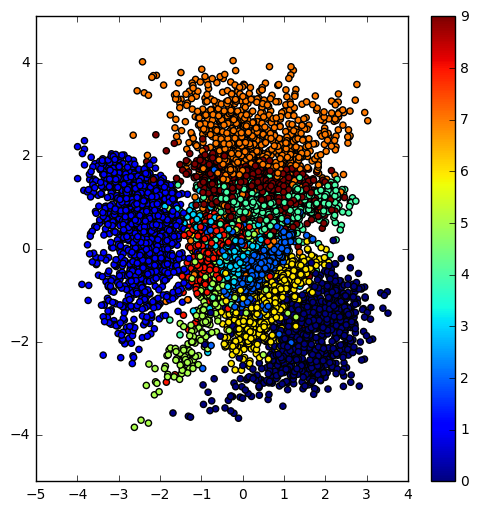

In [27]:
# encoder is the inference network
encoder=Model(X, z_mean)

# a 2d plot of 10 digit classes in latent space
x_test_encoded=encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6,6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test)
plt.colorbar()
plt.show()

Now that we have learned the latent space distribution, we can sample from it and the decoder network maps it to an image similar to our data. So we can now generate images. Pretty cool, eh !?

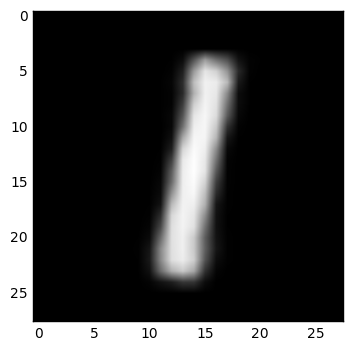

In [28]:
# since the generator treats z as an input, we make z an input layer
z_input=Input(shape=(latent_dim,))
_h_decoded=h_decoder(z_input)
_x_decoded=X_bar(_h_decoded)
generator= Model(z_input, _x_decoded)

z_sample=np.array([np.random.normal(0, 1, 2)])
x_decoded=generator.predict(z_sample)
sampled_im=x_decoded[0].reshape(digit_size,digit_size)
plt.imshow(sampled_im, cmap='Greys_r')
plt.show()

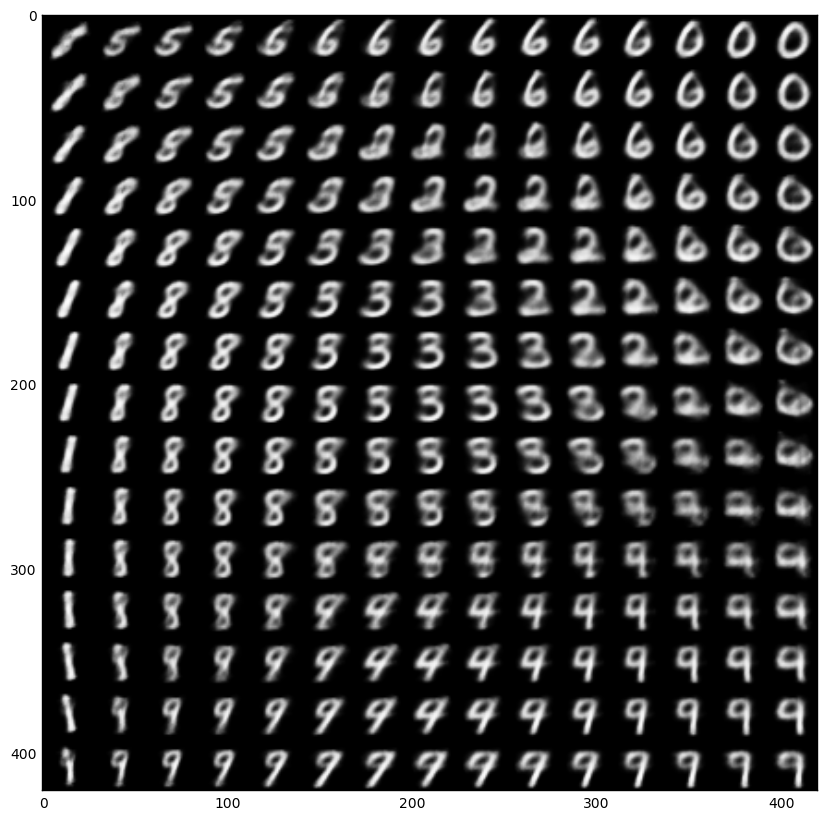

In [29]:
# 2d manifold of images by exploring quantiles of normal dist (using the inverse of cdf)
n=15
figure = np.zeros((digit_size*n, digit_size*n))

grid_x=norm.ppf(np.linspace(0.05,0.95,n))
grid_y=norm.ppf(np.linspace(0.05,0.95,n))

for i, yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        z_sample=np.array([[xi,yi]])
        x_decoded=generator.predict(z_sample)
        digit=x_decoded[0].reshape(digit_size,digit_size)
        figure[i*digit_size:(i+1)*digit_size, 
              j*digit_size:(j+1)*digit_size]=digit
        
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')
plt.show()